# 1.3 Solve a fully-observed inverse problem

Given $x_T$, estimate $x_0$ by matching $G^{(T)}(x_0)$ to $x_T$. Use autodiff on $G$ to calculate gradients of an error metric w.r.t. $x_0$. Compare the resulting rollout to the original `true' simulation.

Compare three approaches:
- $argmin_{x_0} || x_T - G^{(T)}(x_i) ||$, i.e. $T$ steps in one go
- $argmin_{x_i} || x_{i+T_i} - G^{(T_i)}(x_i) ||$, i.e. $T_i$ steps at a time, with $\sum_i T_i = T$. In the extreme case of $T_i=1$, this becomes very similar to implicit numerical methods. Can invertible neural networks help beyond providing better initializations for $x_i$ ? 
- solving backwards: more of the extreme case of $\forall i: T_i=1$, however: Only for some forward numerical solvers can we just reverse time [1] and expect to return to initial conditions. Leap-frog works, but e.g. forward-Euler time-reversed is backward-Euler. 

Generally, how do these approaches differ around \& beyond the horizon of predictability? Which solutions do they pick, and how easy is it to get uncertainties from them?

[1] https://scicomp.stackexchange.com/questions/32736/forward-and-backward-integration-cause-of-errors?noredirect=1&lq=1

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import L96sim

from L96_emulator.util import dtype, dtype_np, device

res_dir = '/gpfs/work/nonnenma/results/emulators/L96/'
data_dir = '/gpfs/work/nonnenma/data/emulators/L96/'

Updating julia wrappers, compilation might take a while....
CUDA not available


/gpfs/home/nonnenma/projects/emulators/simulators/L96/L96sim/L96_base.py:236: UserWarning: Julia is not available, using slower python integrator. Per-seed results will change!!
  warnings.warn("Julia is not available, using slower python integrator. Per-seed results will change!!")


### pick a (trained) emulator

In [55]:
from L96_emulator.run import setup

exp_id = None
if exp_id is None: 
    # loading 'perfect' (up to machine-precision-level quirks) L96 model in pytorch    
    conf_exp = '00_analyticalMinimalConvNet'
else:
    exp_names = os.listdir('experiments/')   
    conf_exp = exp_names[np.where(np.array([name[:2] for name in exp_names])==str(exp_id))[0][0]][:-4]

    args = setup(conf_exp=f'experiments/{conf_exp}.yml')
    args.pop('conf_exp')
    
print('conf_exp', conf_exp)


model_forwarder_str = 'rk4_default'


conf_exp 00_analyticalMinimalConvNet


## plot and compare results

In [56]:

fn = f'fullyobs_initstate_tests_exp{exp_id}_{model_forwarder_str}.npy'
res = np.load(res_dir + 'results/data_assimilation/'+ fn, allow_pickle=True)[()]

loss_vals_LBFGS_full_backsolve=res['loss_vals_LBFGS_full_backsolve']
loss_vals_LBFGS_full_persistence=res['loss_vals_LBFGS_full_persistence']
loss_vals_LBFGS_full_chunks=res['loss_vals_LBFGS_full_chunks']
loss_vals_LBFGS_chunks=res['loss_vals_LBFGS_chunks']
loss_vals_LBFGS_chunks_rollout=res['loss_vals_LBFGS_chunks_rollout']

time_vals_LBFGS_full_backsolve=res['time_vals_LBFGS_full_backsolve']
time_vals_LBFGS_full_persistence=res['time_vals_LBFGS_full_persistence']
time_vals_LBFGS_full_chunks=res['time_vals_LBFGS_full_chunks']
time_vals_LBFGS_chunks=res['time_vals_LBFGS_chunks']
time_vals_backsolve=res['time_vals_backsolve']


state_mses_LBFGS_full_backsolve=res['state_mses_LBFGS_full_backsolve']
state_mses_LBFGS_full_persistence=res['state_mses_LBFGS_full_persistence']
state_mses_LBFGS_full_chunks=res['state_mses_LBFGS_full_chunks']
state_mses_LBFGS_chunks=res['state_mses_LBFGS_chunks']
state_mses_backsolve=res['state_mses_backsolve']
            
x_sols_LBFGS_full_backsolve=res['x_sols_LBFGS_full_backsolve'] 
x_sols_LBFGS_full_persistence=res['x_sols_LBFGS_full_persistence']
x_sols_LBFGS_full_chunks=res['x_sols_LBFGS_full_chunks']
x_sols_LBFGS_chunks=res['x_sols_LBFGS_chunks']
x_sols_backsolve=res['x_sols_backsolve']

targets=res['targets']
initial_states=res['initial_states']

J = res['J']
n_steps = res['n_steps']
n_chunks = res['n_chunks']
T_rollout = res['T_rollout']
dt = res['dt']
back_solve_dt_fac=res['back_solve_dt_fac']


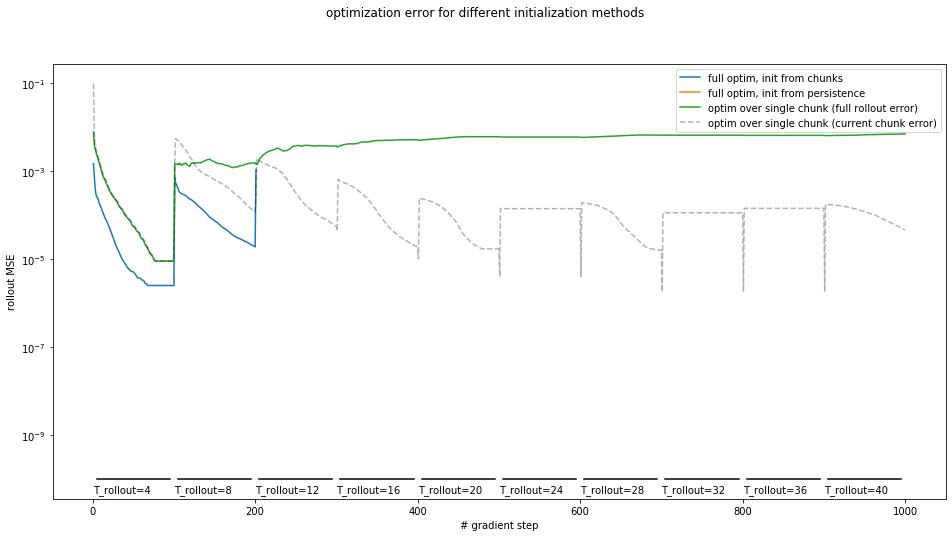

In [57]:
appr_names = [#'full optim, init from backsolve', 
              'full optim, init from chunks',
              'full optim, init from persistence',
              'optim over single chunk (full rollout error)']
all_losses = [#loss_vals_LBFGS_full_backsolve, 
              loss_vals_LBFGS_full_chunks, 
              loss_vals_LBFGS_full_persistence, 
              loss_vals_LBFGS_chunks_rollout]

plt.figure(figsize=(16,8))
for i,loss in enumerate(all_losses):
    xx = np.arange(len(loss))+1 if len(loss) == 1000 else np.arange(0, 10*len(loss), 10)+1
    plt.semilogy(xx, loss, label=appr_names[i])        

try:
    loss = loss_vals_LBFGS_chunks
    xx = np.arange(len(loss))+1 if len(loss) == 1000 else np.arange(0, 10*len(loss), 10)+1
    plt.semilogy(xx, loss, 'k--', alpha=0.3, label='optim over single chunk (current chunk error)')        
except:
    pass

for i in range(n_chunks):
    plt.semilogy(n_steps//n_chunks*i + n_steps//n_chunks*np.array([0.05, 0.95]), 1e-10*np.ones(2), 'k')
    plt.text(i*(n_steps//n_chunks), 5e-11, f'T_rollout={(i+1)*T_rollout//n_chunks}')

plt.legend()
plt.xlabel('# gradient step')
plt.ylabel('rollout MSE')
plt.suptitle('optimization error for different initialization methods')
plt.show()

[0.09888165 0.26616508 0.47833407 0.7368887  1.0329034  1.3369296
 1.6298628  1.903938   2.151668   2.3698502 ]


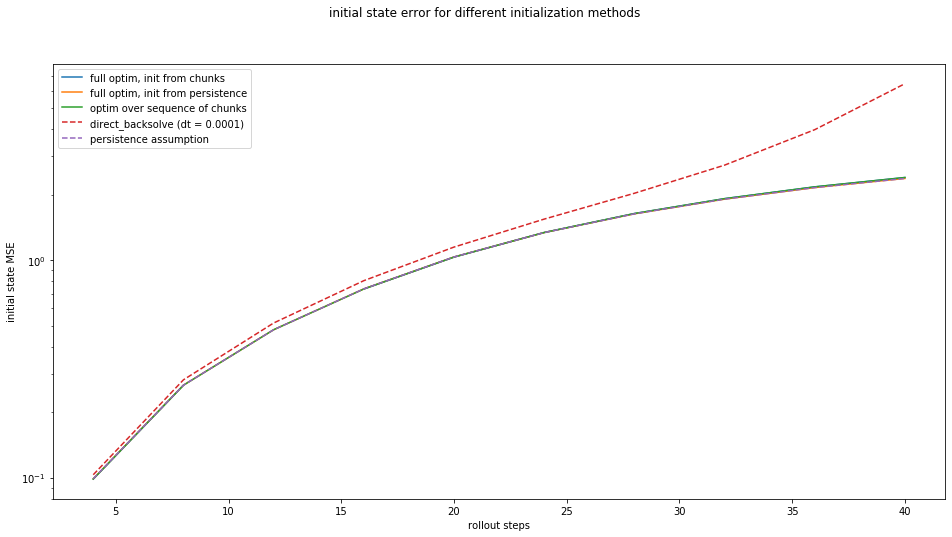

In [58]:
from L96_emulator.util import sortL96fromChannels, sortL96intoChannels

state_mses_persistence = np.array([((targets - initial_states[n_chunks-1-j])**2).mean() for j in range(n_chunks)])
#state_mses_persistence = np.array([((sortL96intoChannels(x_sols_LBFGS_chunks[j],J=J) - initial_states[n_chunks-1-j])**2).mean() for j in range(n_chunks)])
#state_mses_persistence = np.array([((sortL96intoChannels(x_sols_LBFGS_full_persistence[j],J=J) - targets)**2).mean() for j in range(n_chunks)])

print(state_mses_persistence)

appr_names = [#'full optim, init from backsolve', 
              'full optim, init from chunks',
              'full optim, init from persistence',
              'optim over sequence of chunks',
              f'direct_backsolve (dt = {dt/back_solve_dt_fac})',
              'persistence assumption'
             ]
all_mses = [#state_mses_LBFGS_full_backsolve, 
            state_mses_LBFGS_full_chunks,
            state_mses_LBFGS_full_persistence, 
            state_mses_LBFGS_chunks]

plt.figure(figsize=(16,8))
for i,mse in enumerate(all_mses):
    xx = (np.arange(10) + 1) * T_rollout//n_chunks
    plt.semilogy(xx, mse, label=appr_names[i])        

xx = (np.arange(10) + 1) * T_rollout//n_chunks
plt.semilogy(xx, state_mses_backsolve, '--', label=appr_names[-2])        

xx = (np.arange(10) + 1) * T_rollout//n_chunks
plt.semilogy(xx, state_mses_persistence, '--', label=appr_names[-1])        

plt.legend()
plt.xlabel('rollout steps')
plt.ylabel('initial state MSE')
plt.suptitle('initial state error for different initialization methods')
plt.show()

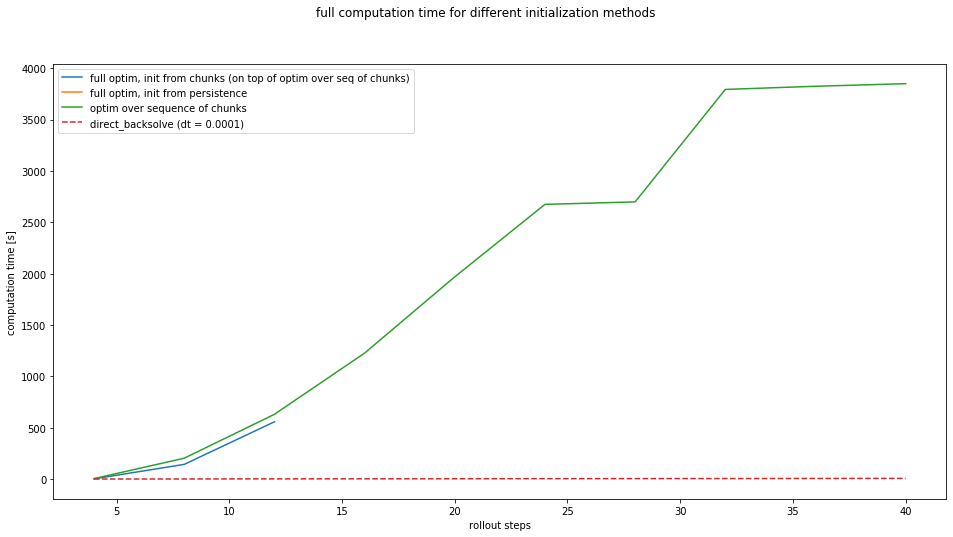

In [59]:
all_times =  [#time_vals_LBFGS_full_backsolve, 
              time_vals_LBFGS_full_chunks, 
              time_vals_LBFGS_full_persistence, 
              time_vals_LBFGS_chunks]

appr_names = [#'full optim, init from backsolve', 
              'full optim, init from chunks (on top of optim over seq of chunks)',
              'full optim, init from persistence',
              'optim over sequence of chunks',
              f'direct_backsolve (dt = {dt/100})']

plt.figure(figsize=(16,8))
for i, tms in enumerate(all_times):
    tms[np.where(tms > 1e6)[0]] = np.nan
    xx = (np.arange(10) + 1) * T_rollout//n_chunks
    plt.plot(xx, tms[::n_steps//n_chunks], label=appr_names[i])        

plt.plot(xx, time_vals_backsolve[:10], '--', label=appr_names[-1])        


plt.legend()
plt.xlabel('rollout steps')
plt.ylabel('computation time [s]')
plt.suptitle('full computation time for different initialization methods')
plt.show()

## compare against backsolve

In [8]:
"""
import time
from L96_emulator.eval import Rollout

if J > 0:
    def negfun(t, x):
        return - f2(x, F, h, b, c, dX_dt, K, J)
else:
    def negfun(t, x):
        return - f1(x, F, dX_dt, K)

n_steps, lr, weight_decay = 200, 1.0, 0.0

loss_vals_backsolve = np.zeros(n_steps)
time_vals_backsolve = time.time() * np.ones(n_steps)

target = out[n_starts+T_rollout]
state_mses_backsolve = np.zeros(n_chunks)

x_init = np.zeros((len(n_starts), K*(J+1)))

i_ = 0

plt.figure(figsize=(12, 4))
for c_, dt_fac in enumerate([1, 10, 100, 1000]):
    plt.subplot(1,4,c_+1)
    for j in range(n_chunks):

        T_i = (j+1)*T_rollout//n_chunks
        times = np.linspace(0, dt*T_i, dt_fac*T_i+1)
        print('backward solving')
        for i__ in range(len(n_starts)):
            out2 = rk4_default(fun=negfun, y0=out[n_starts[i__]+T_rollout].copy(), times=times)
            x_init[i__] = out2[-1].copy()
        state_mses_backsolve[j] = ((x_init - target)**2).mean()
    plt.plot(T_rollout//n_chunks*np.arange(1,n_chunks+1), state_mses_backsolve)
    plt.xlabel('T_rollout')
    plt.ylabel('MSE of iniitial state estimate')
    plt.title(f'dt={dt/dt_fac}')
plt.show()
"""

"\nimport time\nfrom L96_emulator.eval import Rollout\n\nif J > 0:\n    def negfun(t, x):\n        return - f2(x, F, h, b, c, dX_dt, K, J)\nelse:\n    def negfun(t, x):\n        return - f1(x, F, dX_dt, K)\n\nn_steps, lr, weight_decay = 200, 1.0, 0.0\n\nloss_vals_backsolve = np.zeros(n_steps)\ntime_vals_backsolve = time.time() * np.ones(n_steps)\n\ntarget = out[n_starts+T_rollout]\nstate_mses_backsolve = np.zeros(n_chunks)\n\nx_init = np.zeros((len(n_starts), K*(J+1)))\n\ni_ = 0\n\nplt.figure(figsize=(12, 4))\nfor c_, dt_fac in enumerate([1, 10, 100, 1000]):\n    plt.subplot(1,4,c_+1)\n    for j in range(n_chunks):\n\n        T_i = (j+1)*T_rollout//n_chunks\n        times = np.linspace(0, dt*T_i, dt_fac*T_i+1)\n        print('backward solving')\n        for i__ in range(len(n_starts)):\n            out2 = rk4_default(fun=negfun, y0=out[n_starts[i__]+T_rollout].copy(), times=times)\n            x_init[i__] = out2[-1].copy()\n        state_mses_backsolve[j] = ((x_init - target)**2).mean(

### compare with plain gradient descent (SGD with single data point)

In [9]:
"""

import time
from L96_emulator.eval import Rollout


n_starts = np.array([5000, 10000, 15000])
T_rollout, N = 100, len(n_starts)
n_chunks = 20

target = torch.as_tensor(out[n_starts+T_rollout], dtype=dtype, device=device)

x_init = out[n_starts+T_rollout].copy()
roller_outer_SGD = Rollout(model_forward, prediction_task='state', K=K, J=J, N=N, x_init=x_init)
x_init = roller_outer_SGD.X.detach().cpu().numpy().copy()

n_steps, lr, weight_decay = 500, 0.01, 0.0
roller_outer_SGD.train()

optimizer = torch.optim.Adam(roller_outer_SGD.parameters(), lr=lr, weight_decay=weight_decay)

#optimizer = torch.optim.LBFGS(params=roller_outer.parameters(), 
#                              lr=lr, 
#                              max_iter=20, 
#                              max_eval=None, 
#                              tolerance_grad=1e-07, 
#                              tolerance_change=1e-09, 
#                              history_size=100, 
#                              line_search_fn=None)
loss_vals_SGD = np.zeros(n_steps)
time_vals_SGD = time.time() * np.ones(n_steps)
for i in range(n_steps):
        optimizer.zero_grad()
        loss = ((roller_outer_SGD.forward(T=T_rollout) - target)**2).mean()
        loss.backward()
        optimizer.step()
        loss_vals_SGD[i] = loss.detach().cpu().numpy()
        time_vals_SGD[i] = time.time() - time_vals_SGD[i]
        print((time_vals_SGD[i], loss_vals_SGD[i]))
        
plt.figure(figsize=(8,2))
plt.semilogy(loss_vals_SGD, label='initialization')
plt.title('rollout final state loss across gradient descent steps')
plt.ylabel('MSE)')
plt.xlabel('gradient step')
plt.show()

"""

"\n\nimport time\nfrom L96_emulator.eval import Rollout\n\n\nn_starts = np.array([5000, 10000, 15000])\nT_rollout, N = 100, len(n_starts)\nn_chunks = 20\n\ntarget = torch.as_tensor(out[n_starts+T_rollout], dtype=dtype, device=device)\n\nx_init = out[n_starts+T_rollout].copy()\nroller_outer_SGD = Rollout(model_forward, prediction_task='state', K=K, J=J, N=N, x_init=x_init)\nx_init = roller_outer_SGD.X.detach().cpu().numpy().copy()\n\nn_steps, lr, weight_decay = 500, 0.01, 0.0\nroller_outer_SGD.train()\n\noptimizer = torch.optim.Adam(roller_outer_SGD.parameters(), lr=lr, weight_decay=weight_decay)\n\n#optimizer = torch.optim.LBFGS(params=roller_outer.parameters(), \n#                              lr=lr, \n#                              max_iter=20, \n#                              max_eval=None, \n#                              tolerance_grad=1e-07, \n#                              tolerance_change=1e-09, \n#                              history_size=100, \n#                             

# share notebook results via html file

In [ ]:
!jupyter nbconvert --output-dir='/gpfs/home/nonnenma/projects/lab_coord/mdml_wiki/marcel/emulators' --to html data_assimilation.ipynb